By [Kevin Michalewicz](https://kevinmichalewicz.com) on January 2023

This notebook details how to jointly deconvolve four images of a lensed quasar using STARRED. 

> **Warning**
> This is a difficult deconvolution, because the object in question is the faintest know lensed quasar, and we only have shallow survey data. On a CPU, running this notebook will take at least 10 minutes.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint

from copy import deepcopy
from matplotlib import colors
%matplotlib notebook

from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss
from starred.utils.optimization import Optimizer
from starred.utils.noise_utils import propagate_noise
from starred.deconvolution.parameters import ParametersDeconv
from starred.plots.plot_function import view_deconv_model

# Loading data, defining parameters

In [2]:
# hyperparameters of regularization:
lambda_scales = 1.0 
lambda_hf = 10. 
# these should be ~ 1, but you can adjust them.
subsampling_factor = 2 # the upsampling we used to represent the PSF

data_path = 'data/3_observations'
psf_path = 'data/3_psfs'


In [3]:
# Retrieving data
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
data = np.array([np.load(f) for f in file_paths])
# data: one image per epoch. shape: (epochs, npix, npix)
epochs = data.shape[0]
im_size = data.shape[1]

print(data.shape)

(4, 32, 32)


In [4]:
# Retrieving the PSF 
file_paths = sorted(glob.glob(os.path.join(psf_path, '*.npy')))
s = np.array([np.load(f) for f in file_paths])
im_size_up = s.shape[1]


print(s.shape)

(4, 64, 64)


Let's see what the data looks like.

<IPython.core.display.Javascript object>


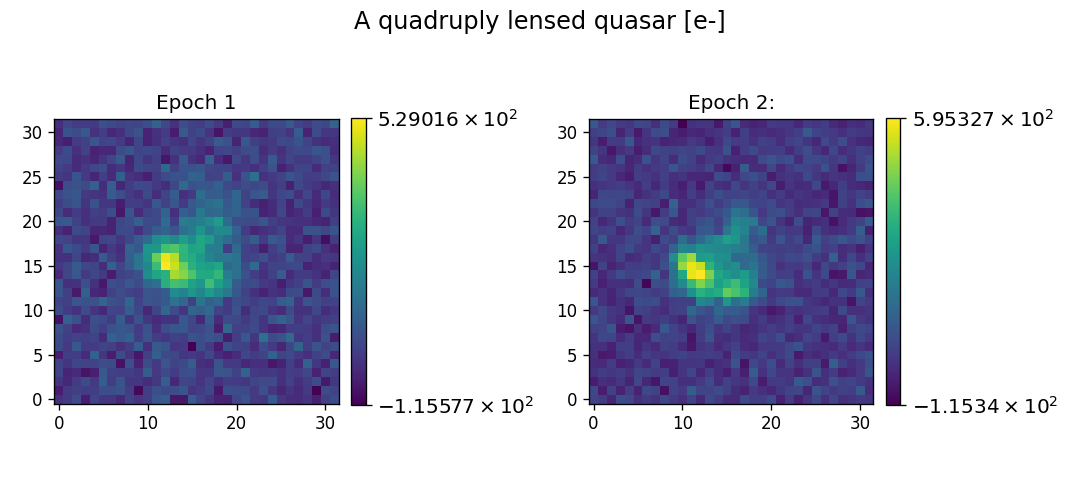

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Epoch 1', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Epoch 2:', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
plt.suptitle('A quadruply lensed quasar [e-]')
fig.colorbar(axs[0].imshow(data[0,:,:], norm=colors.SymLogNorm(linthresh=1e3), origin='lower'), 
             ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(data[1,:,:], norm=colors.SymLogNorm(linthresh=1e3), origin='lower'), 
             ax=axs[1], fraction=fraction, pad=pad)
plt.tight_layout()
plt.show()

In [6]:
# Noise map
sigma_2 = np.zeros((epochs, im_size, im_size))
sigma_sky_2 = np.array([np.std(data[i,int(0.9*im_size):,int(0.9*im_size):]) for i in range(epochs)]) ** 2

for i in range(epochs):
    sigma_2[i,:,:] = sigma_sky_2[i] + data[i,:,:].clip(min=0)

In [7]:
# Parameter initialization

# positions of the point sources.
# they are given starting from the center
# of the image, in pixels.
# we can measure them from the plot above.
# (matplotlib gives us the coordinates upon hovering)
# then we subtract half the size of the image to center them.
offset = (im_size-1)/2.
initial_c_x = np.array([12.28, 13.62, 17.13, 17.6]) - offset
initial_c_y = np.array([15.53, 14.27, 12.73, 20.1]) - offset

# we give the inital amplitude for one epoch. The setup function
# replicates them for all epochs. You can fine tune this later
# if you feel like your amplitudes are widely different on an
# epoch-per-epoch basis.
initial_a = [5500, 5000, 5000, 3000]

# the setup function gives us a model class, with
# dictionaries of parameters.
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       initial_a,
                                                                       subsampling_factor)



# we can modify them if we want to.
# for example, let's shift the second epoch slightly
# to match our data better:
kwargs_init['kwargs_analytic']['dx'][0] = -1.1
kwargs_init['kwargs_analytic']['dy'][0] = -1.3
# (index is 0 because 1st epoch does not have a translation.)

# same applies for the upper and lower boundaries, you can
# tune them.

# print our initial parameters:
pprint(kwargs_init)

{'kwargs_analytic': {'a': array([8.90065272, 8.09150248, 8.09150248, 4.85490149, 8.90065272,
       8.09150248, 8.09150248, 4.85490149, 8.90065272, 8.09150248,
       8.09150248, 4.85490149, 8.90065272, 8.09150248, 8.09150248,
       4.85490149]),
                     'c_x': array([-6.44, -3.76,  3.26,  4.2 ]),
                     'c_y': array([ 0.06, -2.46, -5.54,  9.2 ]),
                     'dx': array([-1.1,  0. ,  0. ]),
                     'dy': array([-1.3,  0. ,  0. ])},
 'kwargs_background': {'h': array([0., 0., 0., ..., 0., 0., 0.]),
                       'mean': array([0., 0., 0., 0.])}}


************************************************************************************************


Now we can check whether our initial guess is good, and iterate back to the previous cell if it isn't.

In [8]:
# utility function to view all epochs of our deconvolution.
# use the slider for this.
view_deconv_model(model, kwargs_init, data, sigma_2)

<IPython.core.display.Javascript object>

# Tuning

In [9]:
# to use the starlet regularization properly, we need to
# calculate how our noise propagates in the wavelet scales:
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_init, 
                    wavelet_type_list=['starlet'], method='MC', 
                    num_samples=500, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]


# Raising the background
Since our point sources were fitting the data quite well, let's fix their positions. We'll optimize everything but the positions in a first step.

optax.adabelief: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 410.21it/s]


<IPython.core.display.Javascript object>


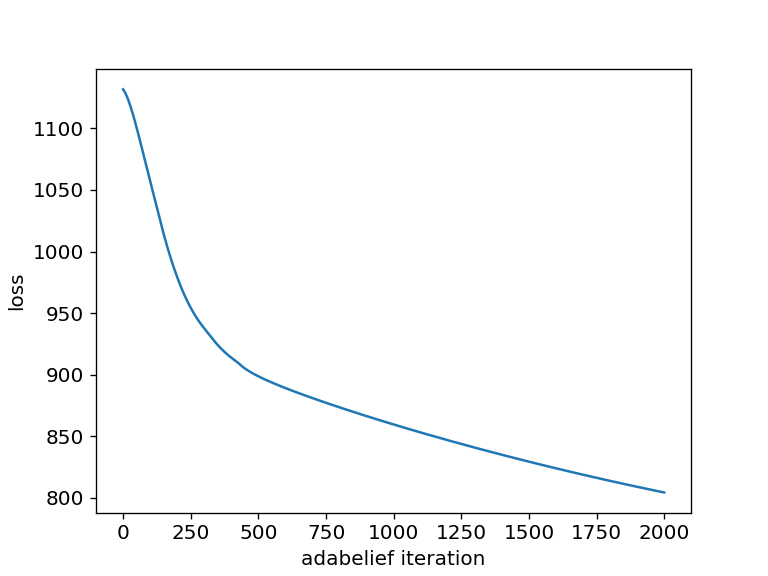

In [10]:
# release our background:
kwargs_fixed['kwargs_background'] = {}
# fix the positions:
kwargs_fixed['kwargs_analytic'] = {'c_x': kwargs_init['kwargs_analytic']['c_x'],
                                   'c_y': kwargs_init['kwargs_analytic']['c_y']}

# make a new param class to inform the model of
# the new set of parameters to optimize:
parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

# loss ...
loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=lambda_scales, 
            regularization_strength_hf=lambda_hf,
            W=W) 



optim = Optimizer(loss, parameters, method='adabelief')
optimiser_option = {
                     'max_iterations':2000, 'min_iterations':None,
                     'init_learning_rate':1e-3, 'schedule_learning_rate':True,
                     'restart_from_init':True, 'stop_at_loss_increase':False,
                     'progress_bar':True, 'return_param_history':True
                   } 

_ = optim.minimize(**optimiser_option) 

# check our loss history:
plt.figure()
plt.plot(optim.loss_history);
plt.xlabel('adabelief iteration');
plt.ylabel('loss');

kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))



# Tuning everything at once
We now probably have a background that looks like a lensing galaxy. Let us fine tune everything by optimizing every parameter of the model simultaneously.

In [11]:
# release the positions::
kwargs_fixed['kwargs_analytic'] = {}

# make a new param class to inform the model of
# the new set of parameters to optimize:
parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

# loss ...
loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=lambda_scales, 
            regularization_strength_hf=10*lambda_hf,
            W=W) 


# small learning rate and many epochs to make sure
# we do not overshoot at any point.
# this is will take a lot of time on CPU, probably ~10 minutes
optim = Optimizer(loss, parameters, method='adabelief')
optimiser_option = {
                     'max_iterations':25000, 'min_iterations':None,
                     'init_learning_rate':2e-3, 'schedule_learning_rate':False,
                     'restart_from_init':True, 'stop_at_loss_increase':False,
                     'progress_bar':True, 'return_param_history':True
                   } 

_ = optim.minimize(**optimiser_option) 

# check our loss history:
plt.figure()
plt.plot(optim.loss_history);
plt.xlabel('adabelief iteration');
plt.ylabel('loss');

optax.adabelief: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:18<00:00, 1380.49it/s]


<IPython.core.display.Javascript object>

In [12]:
# Printing and visualizing the final results
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
pprint(kwargs_final)
view_deconv_model(model, kwargs_final, data, sigma_2)

{'kwargs_analytic': {'a': DeviceArray([ 9.598561 ,  6.8899255,  6.420975 ,  3.9317904, 10.344862 ,
              8.193464 ,  8.373762 ,  4.597509 ,  9.799901 ,  7.704124 ,
              8.940387 ,  4.638512 ,  9.424116 ,  7.952278 ,  8.259424 ,
              3.5023217], dtype=float32),
                     'c_x': DeviceArray([-6.562071 , -3.9240763,  4.061255 ,  4.096573 ], dtype=float32),
                     'c_y': DeviceArray([ 1.3156003, -2.6081507, -4.0729275,  8.485185 ], dtype=float32),
                     'dx': DeviceArray([-2.1672945, -0.4819638, -0.1746049], dtype=float32),
                     'dy': DeviceArray([-1.3453009 ,  0.47956327,  0.01483204], dtype=float32)},
 'kwargs_background': {'h': DeviceArray([-0.07294171, -0.13132718, -0.19072208, ..., -0.19034354,
             -0.14809869, -0.0841696 ], dtype=float32),
                       'mean': DeviceArray([2.4209936, 1.1561574, 1.9087306, 2.502085 ], dtype=float32)}}


<IPython.core.display.Javascript object>

Now we will make a more customized plot, so we can show how to retrieve the different elements of the deconvolution from the model.

In [13]:
# Retrieving different elements of the deconvolved image
epoch = 1
output = model.model(kwargs_final)[epoch] 
deconv, h = model.getDeconvolved(kwargs_final, epoch)

data_show = data[epoch,:,:] 

dif = data_show - output
rr = np.abs(dif) / np.sqrt(sigma_2[epoch,:,:])


fig, axs = plt.subplots(2, 3, figsize=(9.5,5.5))
fraction = 0.046
pad = 0.04
font_size = 10
ticks_size = 6



plt.rc('font', size=font_size)           
axs[0,0].set_title('Data [ADU]', fontsize=8)
axs[0,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,1].set_title('Convolving back [ADU]', fontsize=8)
axs[0,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,2].set_title('Map of relative residuals', fontsize=8)
axs[0,2].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,1].set_title('Background [ADU]', fontsize=8)
axs[1,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,0].set_title('Deconvolved image [ADU]', fontsize=8)
axs[1,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,2].set_title('Narrow PSF', fontsize=8)
axs[1,2].tick_params(axis='both', which='major', labelsize=ticks_size)

fig.colorbar(axs[0,0].imshow(data_show, norm=colors.SymLogNorm(linthresh=5e2), origin='lower'), 
             ax=axs[0,0], fraction=fraction, pad=pad, format='%.0e')

fig.colorbar(axs[0,1].imshow(output, norm=colors.SymLogNorm(linthresh=5e2), origin='lower'), 
             ax=axs[0,1], fraction=fraction, pad=pad, format='%.0e') 

fig.colorbar(axs[0,2].imshow(rr, norm=colors.LogNorm(vmin=0.1), origin='lower'), 
             ax=axs[0,2], fraction=fraction, pad=pad, format='%.0e') 

fig.colorbar(axs[1,1].imshow(h, norm=colors.SymLogNorm(linthresh=100, vmin=0), origin='lower'), 
             ax=axs[1,0], fraction=fraction, pad=pad, format='%.0e') 

fig.colorbar(axs[1,0].imshow(deconv, norm=colors.SymLogNorm(linthresh=200), origin='lower'), 
             ax=axs[1,1], fraction=fraction, pad=pad, format='%.0e') 

fig.colorbar(axs[1,2].imshow(s[epoch,:,:], norm=colors.SymLogNorm(linthresh=1e-3), origin='lower'), 
             ax=axs[1,2], fraction=fraction, pad=pad, format='%.0e') 
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [14]:
output_folder = './output/DELV_test'

# Uncomment the following line to save the obtained deconvolved image
# np.save(os.path.join(output_folder,'deconvolved.npy'), output)
#from astropy.io import fits
##
##
#hdu = fits.PrimaryHDU(data=data_show)
#hdu.writeto(os.path.join(output_folder, 'data%i.fits'%epoch), overwrite=True)
##
#hdu = fits.PrimaryHDU(data=rr)
#hdu.writeto(os.path.join(output_folder, 'residuals%i.fits'%epoch), overwrite=True)
##
#hdu = fits.PrimaryHDU(data=h)
#hdu.writeto(os.path.join(output_folder, 'background%i.fits'%epoch), overwrite=True)
##
#hdu = fits.PrimaryHDU(data=deconv)
#hdu.writeto(os.path.join(output_folder, 'output%i.fits'%epoch), overwrite=True)
#
##
#hdu = fits.PrimaryHDU(data=s[epoch,:,:])
#hdu.writeto(os.path.join(output_folder, 's%i.fits'%epoch), overwrite=True)
#



In [15]:
# getting the positions of the point sources in arcsecond:
pixsize = 0.238
print(kwargs_final['kwargs_analytic']['c_x'] * (pixsize/subsampling_factor))
print(kwargs_final['kwargs_analytic']['c_y'] * (pixsize/subsampling_factor))

[-0.7808865  -0.46696508  0.48328936  0.48749217]
[ 0.15655644 -0.31036994 -0.4846784   1.009737  ]
